## Dependencias

In [72]:
import numpy as np
import pandas as pd
import datetime as datetime

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import f_regression

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf

cf.go_offline()

## Lectura de datos

In [73]:
ruta='/home/oscarjarillo/Documentos/Análisis Multivariado/Regresión_Lineal/insurance.csv'
df = pd.read_csv(ruta)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [74]:
df.shape

(1338, 7)

In [75]:
for v in df.columns:
    if df[v].dtype == 'object':
        for a,b in zip(list(df[v].unique()),range(0,len(list(df[v].unique()))+1)):
            df.loc[df[v]==a,v] = b
        df[v] = pd.to_numeric(df[v])

In [76]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,0,0,16884.92400
1,18,1,33.770,1,1,1,1725.55230
2,28,1,33.000,3,1,1,4449.46200
3,33,1,22.705,0,1,2,21984.47061
4,32,1,28.880,0,1,2,3866.85520


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   int64  
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   int64  
 5   region    1338 non-null   int64  
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(5)
memory usage: 73.3 KB


## Definición de variables

In [78]:
df.insert(0,'id',df.index+1)
df.head()

,id,age,sex,bmi,children,smoker,region,charges
0,1,19,0,27.900,0,0,0,16884.92400
1,2,18,1,33.770,1,1,1,1725.55230
2,3,28,1,33.000,3,1,1,4449.46200
3,4,33,1,22.705,0,1,2,21984.47061
4,5,32,1,28.880,0,1,2,3866.85520


In [79]:
um = ['id']
vart = ['charges']
varc = [v for v in df.columns if v not in um and v not in vart]

## Análisis exploratorio

### Valores nulos

In [80]:
nulos = 1-df.describe().T[['count']]/len(df)
nulos

,count
id,0.0
age,0.0
sex,0.0
bmi,0.0
children,0.0
smoker,0.0
region,0.0
charges,0.0


### Valores extremos

In [81]:
X = df[varc].copy()

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'sex'}>],
       [<AxesSubplot:title={'center':'bmi'}>,
        <AxesSubplot:title={'center':'children'}>],
       [<AxesSubplot:title={'center':'smoker'}>,
        <AxesSubplot:title={'center':'region'}>]], dtype=object)

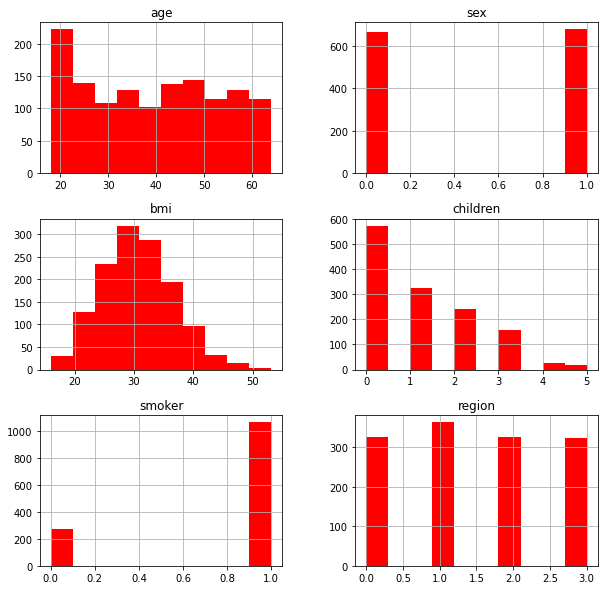

In [82]:
X.hist(figsize=(10,10),color='red')

In [83]:
for v,li,ls in X.describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    X[f'ex_{v}'] = ((X[v]<li)|(X[v]>ls)).astype(int)
X['ex_'] = X.filter(like='ex_').max(axis=1)
X['ex_'].value_counts(1)

0    0.979073
1    0.020927
Name: ex_, dtype: float64

In [84]:
X[um+vart] = df[um+vart]

In [85]:
X = X.loc[X['ex_']==0].drop(X.filter(like='ex_').columns,axis=1).reset_index(drop=True)

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'sex'}>],
       [<AxesSubplot:title={'center':'bmi'}>,
        <AxesSubplot:title={'center':'children'}>],
       [<AxesSubplot:title={'center':'smoker'}>,
        <AxesSubplot:title={'center':'region'}>]], dtype=object)

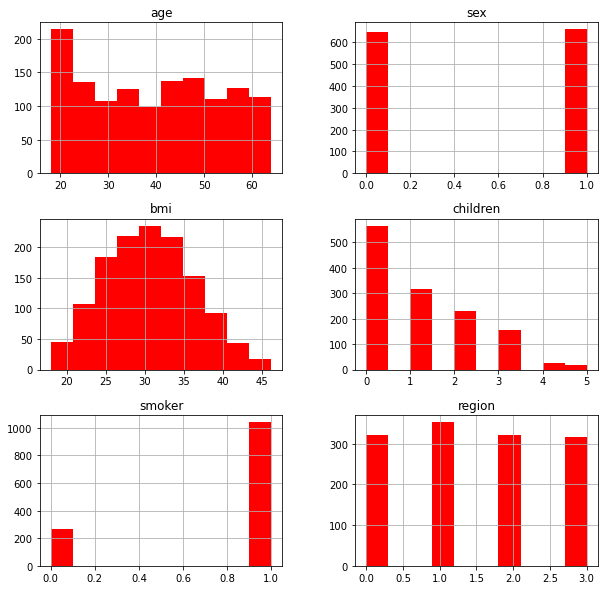

In [86]:
X[varc].hist(figsize=(10,10),color='red')

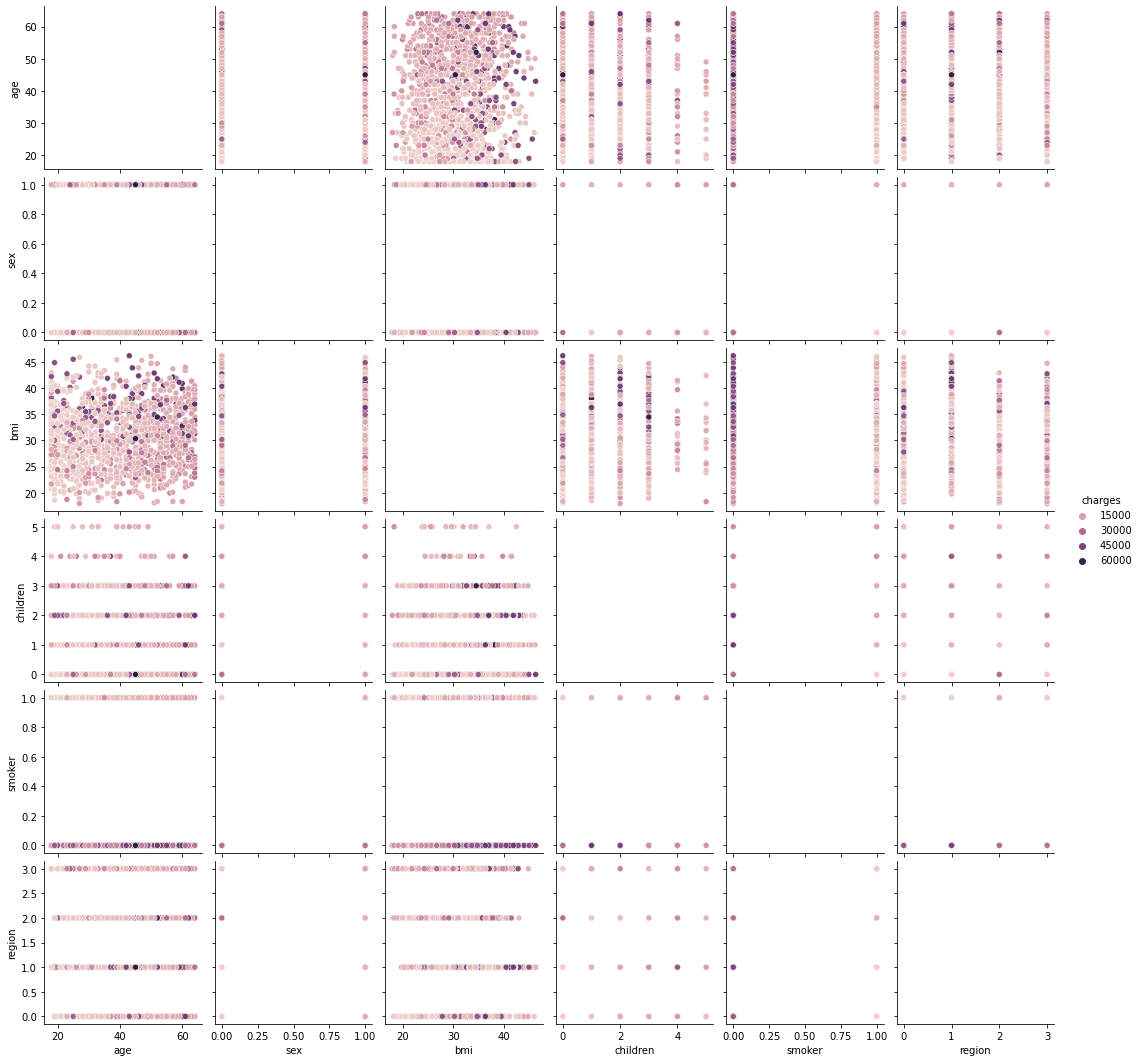

In [87]:
sns.pairplot(data=X[varc+vart],hue=vart[0])

## Partición de aprendizaje

In [88]:
Xt,Xv,yt,yv = train_test_split(X[um+varc],X[um+vart],test_size=0.7)
Xt.reset_index(drop=True,inplace=True)
Xv.reset_index(drop=True,inplace=True)
yt.reset_index(drop=True,inplace=True)
yv.reset_index(drop=True,inplace=True)

## Aprendizaje

In [89]:
hp = dict(alpha = np.arange(0.1,2,0.1))

In [90]:
modelo = Ridge()

In [91]:
grid = GridSearchCV(param_grid=hp,
                   cv=5,
                   scoring='neg_mean_absolute_error',
                   n_jobs=-1,
                   verbose=True,
                   estimator = modelo)

In [92]:
grid.fit(Xt[varc],yt[vart[0]])

Fitting 5 folds for each of 19 candidates, totalling 95 fits


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9])},
             scoring='neg_mean_absolute_error', verbose=True)

In [93]:
grid.best_params_

{'alpha': 0.1}

In [94]:
modelo = grid.best_estimator_
modelo

Ridge(alpha=0.1)

In [95]:
modelo.fit(Xt[varc],yt[vart[0]])

Ridge(alpha=0.1)

In [96]:
modelo.coef_,modelo.intercept_

(array([   281.31634496,    467.68642752,    324.002806  ,    494.92430038,
        -22878.16470196,    431.4574022 ]),
 8874.222221920934)

## Validación del modelo

In [97]:
St = Xt.merge(yt,on=um,how='inner')
Sv = Xv.merge(yv,on=um,how='inner')

In [98]:
St['y^'] = modelo.predict(Xt[varc])
Sv['y^'] = modelo.predict(Xv[varc])

In [99]:
print(mean_absolute_error(y_pred=St['y^'],y_true=St[vart[0]]))
print(mean_absolute_error(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

3972.463404895409
4227.11852770405


<AxesSubplot:ylabel='Density'>

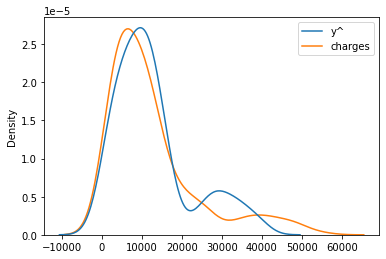

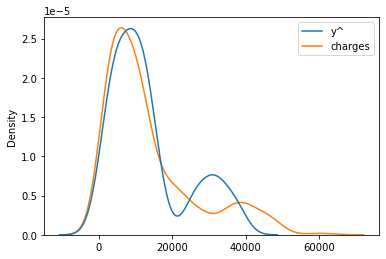

In [100]:
plt.figure()
sns.kdeplot(data=St[['y^']+vart])
plt.figure()
sns.kdeplot(data=Sv[['y^']+vart])